In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from IPython.display import display as pretty

from collections import Counter
from functools import cmp_to_key
from typing import List
from decimal import Decimal
import heapq
from tqdm import trange

import sympy
import numpy as np
import scipy.io as sio
import pysindy as ps
from derivative import dxdt
import sys; sys.path.insert(0, "../")
from best_subset import ps_features, brute_force
from sklearn.model_selection import train_test_split
from okridge.solvel0 import *
from UBIC import *

Sklearn's version: 1.6.1


In [2]:
### Burgers ###
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [3]:
np.random.seed(0)
noise_lv = float(30)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

denoised = True
if denoised: u = np.load("./denoised_files/burgers_dictlearn_denoised30_components32_8x8.npy")

Noise level: 30.0


In [4]:
### GA (Loop of crossover -> mutation -> evaluate_genome) ###
@cmp_to_key
def compare_module(module1, module2):
    if module1 == module2:
        return 0
    lg1 = len(module1); lg2 = len(module2)
    if lg1 != lg2:
        return lg1 - lg2
    if module1 < module2: 
        return -1
    else:
        return 1
    
def generate_module(n_derivatives):
    pde_module = sorted(np.random.randint(0, 3) for i in range(np.random.randint(1, n_derivatives+1)))
    return tuple(pde_module)

def generate_genome(n_modules, n_derivatives):
    genome = fset(generate_module(n_derivatives) for _ in range(n_modules))
    return genome

def generate_chromosome(n_modules, n_derivatives, pop_size):
    chromosome = set()
    count = 0
    while count < pop_size:
        genome = generate_genome(n_modules, n_derivatives)
        if genome not in chromosome:
            chromosome.add(genome)
            count += 1
    return chromosome

def display_derivative(n):
    nx = 'x'*n
    return sympy.symbols(f'u_{nx}')

def display_module(pde_module):
    return np.prod([display_derivative(_) for _ in pde_module])

# coefficients for sorted(encoded_pde)
def display_pde(encoded_pde, coefficients=None):
    if coefficients is None:
        coefficients = [1 for _ in range(len(encoded_pde))]
    out = []
    for module, c in zip(encoded_pde, coefficients):
        out.append(c*display_module(module))
    return sum(out)

# not efficient: O(len(genome))
def crossover(genome1: List, genome2: List, fs=True):
    if genome1 != genome2:
        while True: 
            idx1 = np.random.randint(len(genome1))
            idx2 = np.random.randint(len(genome2))
            if genome1[idx1] != genome2[idx2]:
                break
        genome1[idx1], genome2[idx2] = genome2[idx2], genome1[idx1]
    if fs: 
        genome1, genome2 = fset(genome1), fset(genome2)
    return genome1, genome2

# in-place func
def mutation(genome: List, n_derivatives: int, mutate_rate=(0.4, 0.5, 0.4), fs=True):
    add_rate, delete_rate, order_rate = mutate_rate
    # add
    if np.random.uniform(0, 1) < add_rate:
        genome.append(generate_module(n_derivatives))
    # del
    if np.random.uniform(0, 1) < delete_rate:
        lg = len(genome)
        if lg > 0:
            idx = np.random.randint(lg)
            genome.pop(idx)
    # order
    if np.random.uniform(0, 1) < order_rate:
        lg = len(genome)
        if lg > 0: 
            i = np.random.randint(lg)
            lg = len(genome[i])
            if lg > 0:
                genome[i] = list(genome[i])
                j = np.random.randint(len(genome[i]))
                if genome[i][j] == 0:
                    genome[i][j] = np.random.randint(1, n_derivatives)
                else:
                    genome[i][j] -= 1
                genome[i] = tuple(sorted(genome[i]))
    if fs: 
        genome = fset(genome)
    return genome

def numericalize_module(module, base_features):
    return np.prod([base_features[derivative] for derivative in module], axis=0)

def numericalize_genome(genome, base_features):
    return np.stack([numericalize_module(module, base_features) 
                     for module in genome], axis=-1)

def compute_genome_coefficient(genome, base_features, target):
    features = numericalize_genome(genome, base_features)
    assert target.shape == features[:, :, 0].shape
    n_features = features.shape[-1]
    target = target.reshape(-1, 1)
    features = features.reshape(-1, n_features)
    coeff, error, _, _ = np.linalg.lstsq(features, target, rcond=None)
    return coeff, error[0]

# Computing coefficients + fitness
def evaluate_genome(genome, base_features, target, epsilon=0):
    coeff, mse = compute_genome_coefficient(genome, base_features, target)
    mse = mse / np.prod(target.shape)
    fitness = mse + abs(epsilon)*len(genome)
    return fitness, coeff

### Miscellaneous for GA ###
def sci_format(n):
    sf = '%.2E' % Decimal(n)
    sf = sf.split('E')
    return float(sf[0]), int(sf[1])

def fset(ls): return frozenset(ls)

In [5]:
n_derivatives = 3
n_modules = 3
pop_size = 400
epsilons = [10**(i-6) for i in range(1, 6)] # 1e-5 to 1e-1

# differentiation_method = ps.FiniteDifference(is_uniform=True) # good for noiseless
differentiation_method = ps.SINDyDerivative(kind="kalman", alpha=1e-1, save_smooth=True)
u_t = differentiation_method._differentiate(u.T, t).T
u_x = differentiation_method._differentiate(u, x)
u_xx = differentiation_method._differentiate(u_x, x)
base_features = np.array([u, u_x, u_xx])

In [6]:
genome = generate_genome(n_modules, n_derivatives); print(genome)
print(evaluate_genome(genome, base_features, u_t))
display_pde(genome, [3,4,5])

frozenset({(1,), (2,)})
(0.0008291748061082486, array([[-0.37429506],
       [ 0.10111727]]))


3*u_x + 4*u_xx

## GA (Following the papers) ##

In [7]:
class LargestUniqueHeap:
    def __init__(self, N, decending=True):
        self.N = N
        self.heap = []
        self.unique_values = set()
        self.decending = decending
        
    def add(self, value):
        if value in self.unique_values:
            # Ignore if the value is already in the set (duplicate)
            return
        
        if len(self.heap) < self.N:
            # If the heap has fewer than N elements, add the new value
            heapq.heappush(self.heap, value)
            self.unique_values.add(value)
        elif value > self.heap[0]:
            # If the new value is greater than the smallest in the heap
            smallest = heapq.heappushpop(self.heap, value)
            # Replace the smallest in the set with the new value
            self.unique_values.remove(smallest)
            self.unique_values.add(value)

    def get_largest_values(self):
        # Return the N largest values in ascending order
        return sorted(self.heap, reverse=self.decending)

n_generations = 200
mutate_rate = (0.4, 0.4, 0.4)
min_len_chrom = 5

print("Initialization...")
chrom = generate_chromosome(n_modules, n_derivatives, pop_size)
set_chrom = chrom.copy()
chrom = list(chrom)

fitnesses = [evaluate_genome(genome, base_features, u_t, epsilon=0)[0] for genome in chrom]
epi = 0; min_epi = 0 # epi = -1
epi = 10**(sci_format(np.median(fitnesses))[1]+epi)
epi = max(min_epi, epi)
print('epi =', epi)
best_chrom_fitnesses = LargestUniqueHeap(pop_size)
for i in range(len(fitnesses)):
    fitnesses[i] += epi*len(chrom[i])
    best_chrom_fitnesses.add((-fitnesses[i], chrom[i]))

print("Learning PDEs...")
for g in trange(n_generations):
    children = []
    # crossover
    for _ in range(2):
        chrom_f, chrom_m = train_test_split(chrom, test_size=0.5, train_size=0.5, shuffle=True)
        for genome_f, genome_m in zip(chrom_f, chrom_m):
            child1, child2 = crossover(list(genome_f), list(genome_m))
            children.append(child1)
            children.append(child2)
    # mutation
    for i in range(len(children)):
        child = list(children[i].copy())
        child = mutation(child, n_derivatives, mutate_rate)
        if len(child) > 0:
            children[i] = fset(child)
    # fitness
    children = set(children)
    chrom = []
    for child in children:
        fitness, _ = evaluate_genome(child, base_features, u_t, epsilon=epi)
        chrom.append((fitness, child))
        best_chrom_fitnesses.add((-fitness, child))
    # Creating parent for the next generation
    chrom = sorted(chrom)
    chrom = [genome for _, genome in chrom][:pop_size]
    
best_chrom_fitnesses = [(v, -k) for k, v in best_chrom_fitnesses.get_largest_values()]
best_chrom_fitnesses[:10]

Initialization...
epi = 0.001
Learning PDEs...


100%|█████████████████████████████████████████| 200/200 [02:33<00:00,  1.30it/s]


[(frozenset({(1,)}), 0.002178655073807225),
 (frozenset({(0, 1)}), 0.00239680301754266),
 (frozenset({(1, 1, 1)}), 0.0025627142521097374),
 (frozenset({(0, 1), (2,)}), 0.002616140786340381),
 (frozenset({(0, 2), (1,)}), 0.0027288058224680433),
 (frozenset({(0, 1), (0, 2)}), 0.002752688939863865),
 (frozenset({(0, 0, 2), (1,)}), 0.0027749274301016617),
 (frozenset({(0, 0, 0), (1,)}), 0.002793039300311085),
 (frozenset({(0, 1), (2, 2, 2)}), 0.0028080922360540867),
 (frozenset({(1,), (2,)}), 0.0028291748061082486)]

## GA (V2 implemented by Pongpisit Thanasutives) ##

In [8]:
# n_generations = 200
# mutate_rate = (0.4, 0.4, 0.4)
# min_len_chrom = 5

# print("Initialization...")
# chrom = generate_chromosome(n_modules, n_derivatives, pop_size)
# set_chrom = chrom.copy()
# chrom = list(chrom)

# fitnesses = [evaluate_genome(genome, base_features, u_t, epsilon=0)[0] for genome in chrom]
# epi = 0; epi = 10**(sci_format(np.median(fitnesses))[1]-1+epi)
# # epi = 1e-5 # 1e-4
# print('epi =', epi)
# for i in range(len(fitnesses)):
#     fitnesses[i] += epi*len(chrom[i])
    
# best_chrom_fitnesses = heapq.nsmallest(len(chrom), zip(chrom, fitnesses), 
#                                        key=lambda _: _[1])

# print("Learning PDEs...")
# for _ in trange(n_generations):
#     chrom_f, chrom_m = train_test_split(chrom, test_size=0.5, train_size=0.5, shuffle=True)
#     for genome_f, genome_m in zip(chrom_f, chrom_m):
#         genome_child1, genome_child2 = crossover(list(genome_f), list(genome_m))
#         chrom.append(genome_child1)
#         chrom.append(genome_child2)
#         if genome_child1 not in set_chrom:
#             fitness_child1, _ = evaluate_genome(genome_child1, base_features, u_t, epsilon=epi)
#             best_chrom_fitnesses.append((genome_child1, fitness_child1))
#             set_chrom.add(genome_child1)
#         if genome_child2 not in set_chrom:
#             fitness_child2, _ = evaluate_genome(genome_child2, base_features, u_t, epsilon=epi)
#             best_chrom_fitnesses.append((genome_child2, fitness_child2))
#             set_chrom.add(genome_child2)

#     for i in range(len(chrom)):
#         genome = list(chrom[i].copy())
#         genome = mutation(genome, n_derivatives, mutate_rate)
#         if len(genome) > 0:
#             chrom[i] = fset(genome)
    
#     new_chrom = []; fitnesses = []
#     for i in range(len(chrom)):
#         if chrom[i] not in set_chrom:
#             fitness, _ = evaluate_genome(chrom[i], base_features, u_t, epsilon=epi)
#             best_chrom_fitnesses.append((chrom[i], fitness))
#             new_chrom.append(chrom[i])
#             fitnesses.append(fitness)
#             set_chrom.add(chrom[i])
            
#     best_chrom_fitnesses = heapq.nsmallest(pop_size, best_chrom_fitnesses, key=lambda _ : _[1])
#     chrom_fitnesses = heapq.nsmallest(pop_size, zip(new_chrom, fitnesses), key=lambda _ : _[1])
#     chrom = []; fitnesses = []; del new_chrom
#     for genome, fitness in chrom_fitnesses:
#         chrom.append(genome); fitnesses.append(fitness)
#     if len(chrom) <= min_len_chrom:
#         break

# assert len(chrom) == len(set(chrom))
# # [(frozenset({(0, 1), (2,)}), 0.00020050332746595256),
# #  (frozenset({(0, 1), (1, 1, 2), (2,)}), 0.00030041491578636356),
# #  (frozenset({(0, 1), (1, 2), (2,)}), 0.00030041518841411233),
# #  (frozenset({(0, 1), (0, 1, 2), (2,)}), 0.0003004376828294478),
# #  (frozenset({(0, 0, 1), (0, 1), (2,)}), 0.0003004803064302649),
# #  (frozenset({(0, 0, 0), (0, 1), (2,)}), 0.0003004808326250074),
# #  (frozenset({(0, 0), (0, 1), (2,)}), 0.0003004869577000254),
# #  (frozenset({(0, 1), (1,), (2,)}), 0.0003004883027313859),
# #  (frozenset({(0, 1), (2,), (2, 2, 2)}), 0.0003004915325845),
# #  (frozenset({(0, 1), (1, 1, 1), (2,)}), 0.0003004934561692255)]
# best_chrom_fitnesses[:10]

In [9]:
for potential_pde, _ in best_chrom_fitnesses[:20]:
    potential_pde = sorted(list(potential_pde), key=compare_module)
    pde_coefficient = compute_genome_coefficient(potential_pde, base_features, u_t)[0].flatten()
    pde_coefficient = [round(c, 5) for c in pde_coefficient]
    pretty(display_pde(potential_pde, pde_coefficient))

-0.37437*u_x

-0.86675*u_*u_x

-1.21332*u_x**3

-0.94707*u_*u_x + 0.15335*u_xx

0.20106*u_*u_xx - 0.39255*u_x

-0.95366*u_*u_x + 0.24374*u_*u_xx

0.24261*u_**2*u_xx - 0.3893*u_x

-0.24809*u_**3 - 0.37862*u_x

-0.92653*u_*u_x + 0.19931*u_xx**3

-0.3743*u_x + 0.10112*u_xx

-0.18986*u_*u_xx**2 - 0.38934*u_x

0.28491*u_**2*u_xx - 0.93404*u_*u_x

-0.37798*u_x + 0.14626*u_xx**3

-0.15024*u_**2 - 0.37652*u_x

-0.4029*u_x - 0.13545*u_xx**2

-1.08681*u_*u_x - 0.47481*u_x*u_xx

-0.9763*u_*u_x + 0.86805*u_x**2*u_xx

-0.27392*u_**3 - 0.89215*u_*u_x

-0.93029*u_*u_x - 0.22267*u_*u_xx**2

-0.20968*u_**2 - 1.29962*u_x**3

In [10]:
common_modules = []
for genome, _ in best_chrom_fitnesses:
    common_modules.extend([*genome])
common_modules = Counter(common_modules)
print(list(common_modules.values()))

n_common = 0
cum_v = 0; total_v = sum(common_modules.values())
for _, v in common_modules.most_common():
    cum_v += v; n_common += 1
    print(n_common, cum_v/total_v, end=',')
n_common = 15
print(n_common)

common_modules = Counter(common_modules).most_common(n_common)
common_modules = fset(genome for genome, _ in common_modules)
common_modules = sorted(list(common_modules), key=(compare_module))
X_pre = numericalize_genome(common_modules, base_features).reshape(-1, n_common)
y_pre = u_t.reshape(-1, 1)
feature_names = [sympy.latex(display_module(module)).strip().replace(' ', '') 
                 for module in common_modules]
feature_names

[152, 188, 68, 44, 54, 48, 63, 55, 47, 56, 41, 39, 43, 44, 38, 56, 37, 25, 29]
1 0.1668145519077196,2 0.30168589174800353,3 0.36202307009760426,4 0.4179236912156167,5 0.4676131322094055,6 0.5173025732031943,7 0.5661047027506655,8 0.614019520851819,9 0.6566104702750666,10 0.6983141082519965,11 0.7373558118899733,12 0.7763975155279503,13 0.8145519077196096,14 0.8509316770186336,15 0.8855368234250222,16 0.9192546583850931,17 0.9520851818988465,18 0.9778172138420586,19 1.0,15


['u_{x}',
 'u_{xx}',
 'u_{}^{2}',
 'u_{}u_{x}',
 'u_{}u_{xx}',
 'u_{x}u_{xx}',
 'u_{xx}^{2}',
 'u_{}^{3}',
 'u_{}^{2}u_{x}',
 'u_{}^{2}u_{xx}',
 'u_{}u_{x}u_{xx}',
 'u_{}u_{xx}^{2}',
 'u_{x}^{3}',
 'u_{x}^{2}u_{xx}',
 'u_{xx}^{3}']

In [11]:
coefficients, best_subsets = okridge_solvel0_full(X_pre, y_pre, k=8)
best_subsets

100%|█████████████████████████████████████████████| 8/8 [00:12<00:00,  1.53s/it]


[[0],
 [1, 3],
 [1, 3, 8],
 [3, 4, 5, 7],
 [3, 4, 6, 7, 10],
 [1, 3, 4, 5, 7, 8],
 [3, 4, 5, 6, 7, 8, 12],
 [0, 1, 3, 4, 5, 6, 7, 8]]

In [12]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75

# bics = [sm.OLS(y_pre, X_pre[:, bs]).fit().bic for bs in best_subsets]
# aics = [sm.OLS(y_pre, X_pre[:, bs]).fit().aic for bs in best_subsets]
post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
print(b_bics)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
except IndexError:
    thres = 0.02
min_thres = 0.02
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    bc_seq.append(last_bc)

best_bc = last_bc
alt_bc = bc_seq[-2] if len(bc_seq) > 1 else last_bc-1
cond = abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) or \
        abs((b_bics[last_bc]-b_bics[alt_bc])/(b_bics[alt_bc]*(last_bc-alt_bc)))
if cond < thres: 
    best_bc = alt_bc
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-100970.55609257975, -117731.98877827905, -126783.29939655606, -130330.99150230842, -132195.03860076063, -132962.86999346645, -133178.58075142026, -133386.29544118364]
threshold: 0.05243148481845923
max_lam: 4.063988036092879
1 <---> 4 0.04094907983397044


(4.06398804,
 array([4.70404483e+04, 1.01863407e-10, 1.14229054e+05, 9.85679329e+04,
        1.06183957e+05, 3.61725725e+05, 5.20655173e+05, 5.02903898e+05]),
 1,
 1)

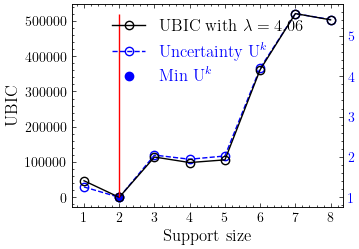

In [13]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
#     ax.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
#                  xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
#                  xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+200000), 
#                  arrowprops={'arrowstyle': '->'})
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), color='red')
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12)
    
    plt.show()